In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import random
from datetime import datetime

# Настройка стиля графиков
sns.set_style("whitegrid")

In [2]:
def generate_last_12_months():
    today = datetime.today()
    current_year = today.year
    current_month = today.month
    months = []
    for i in range(12):
        year = current_year
        month = current_month - i
        if month <= 0:
            month += 12
            year -= 1
        months.append(f"{year}-{month:02d}")
    months.reverse()
    return months

# Функция для генерации данных о продажах с использованием нормального распределения
def generate_sales_dataframe(models, months):
    data = []
    for model in models:
        mean_sales = random.randint(40, 80)  # Среднее значение продаж
        std_dev_sales = random.uniform(5, 15)  # Стандартное отклонение
        
        for month in months:
            # Генерация продаж с использованием нормального распределения
            sales = max(0, int(np.random.normal(mean_sales, std_dev_sales)))
            data.append({
                'Model': model['name'],
                'Month': month,
                'Sales': sales
            })
    return pd.DataFrame(data)

# парсинг XML-файла
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    shop = root.find('shop')
    offers = shop.find('offers').findall('offer')

    models = []
    for offer in offers:
        model_id = offer.get('id')
        model_name = offer.find('name').text
        models.append({'id': model_id, 'name': model_name})
    return models

# Путь к XML файлу
xml_file = '../LR6/couches.xml'
models = parse_xml(xml_file)

# Генерация данных о продажах
months = generate_last_12_months()
sales_df = generate_sales_dataframe(models, months)

# Вывод первых строк DataFrame
print("\nПервые строки таблицы продаж:")
display(sales_df.head())


Первые строки таблицы продаж:


,Model,Month,Sales
0,Кресло Pero с подлокотниками FIRST,2024-04,70
1,Кресло Pero с подлокотниками FIRST,2024-05,67
2,Кресло Pero с подлокотниками FIRST,2024-06,56
3,Кресло Pero с подлокотниками FIRST,2024-07,45
4,Кресло Pero с подлокотниками FIRST,2024-08,49


In [ ]:
sales_df['Month_Num'] = pd.to_datetime(sales_df['Month']).dt.to_period('M').astype(int)


# Разделяем данные на признаки (X) и целевую переменную (y)
X = sales_df[['Month_Num']]  # Признак: номер месяца
y = sales_df['Sales']        # Целевая переменная: продажи

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (28, 1)
Размер тестовой выборки: (8, 1)


In [4]:
# Создаем и обучаем модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Получаем коэффициенты модели
print("\nКоэффициенты модели:")
print(f"Intercept (свободный член): {model.intercept_}")
print(f"Coefficient (коэффициент наклона): {model.coef_[0]}")

# Оценка модели на тестовой выборке
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nМетрики качества модели:")
print(f"MSE (среднеквадратичная ошибка): {mse:.2f}")
print(f"R2 Score (коэффициент детерминации): {r2:.2f}")


Коэффициенты модели:
Intercept (свободный член): -318.3124719605205
Coefficient (коэффициент наклона): 0.5771646478241366

Метрики качества модели:
MSE (среднеквадратичная ошибка): 118.85
R2 Score (коэффициент детерминации): -0.27


In [5]:
# Прогноз на следующий месяц
next_month_num = sales_df['Month_Num'].max() + 1
next_month_sales = model.predict([[next_month_num]])

print(f"\nПрогноз продаж на следующий месяц (месяц {next_month_num}): {next_month_sales[0]:.2f}")


Прогноз продаж на следующий месяц (месяц 663): 64.35


C:\Users\Altxe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


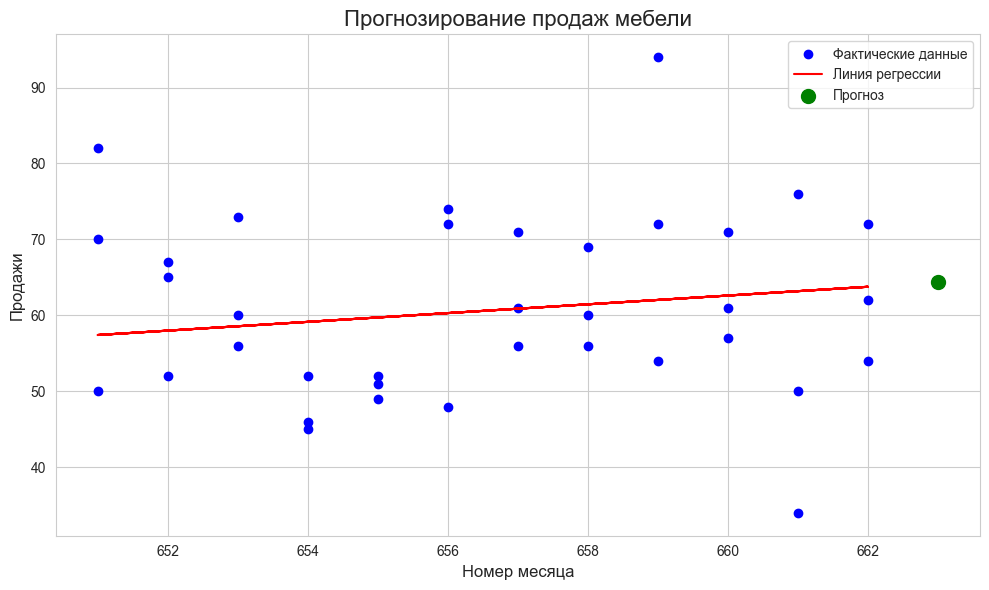

In [6]:
# Визуализация фактических и прогнозируемых данных
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Фактические данные')
plt.plot(X, model.predict(X), color='red', label='Линия регрессии')
plt.scatter([next_month_num], [next_month_sales], color='green', label='Прогноз', s=100)

plt.title('Прогнозирование продаж мебели', fontsize=16)
plt.xlabel('Номер месяца', fontsize=12)
plt.ylabel('Продажи', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()